In [2]:
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd
from IPython import display
import seaborn as sns
from ContributorCentricFunctions import *
%matplotlib inline

In [3]:
years = [2005+i for i in range(12)]
years

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

In [4]:
study_tiles = json.loads(open('study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

Found 9 tiles.


# Study Tiles: Load data for a specific study tile

In [5]:
for idx, tile in enumerate(study_tiles):
    print(idx, tile['name'])

0 Port Au Prince, Haiti
1 Trisuli Bazar, Nepal
2 Tacloban
3 Kenema, Sierra Leone
4 Monrovia, Liberia
5 Kathmandu, Nepal
6 Heidelberg, Germany
7 London
8 Manhattan, NY


## 1. Get the `user_list` by setting the `study_tile_idx` to the appropriate study tile

In [6]:
study_tile_idx = 0

In [7]:
reset() #Safety for the db connections
study_tiles[study_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

In [8]:
print("Found: {0} users".format(len(study_tiles[study_tile_idx]['user_list'])))

Found: 440 users


## 2. Build the User Distributions
If this doesn't run, run the cell 2 above again)

In [9]:
study_tiles[study_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['user_list'])
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['df'].head(2))

 2194/ ~ 2112

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,102322322323,2005,143,0,0.0,0,5,1,143,sxpert,2005,0,0.0,0,1154,5
1,120032111012,2005,143,0,0.0,0,12,1,143,sxpert,2005,0,0.0,0,1154,5


## 3. Get tile focus for each user

In [10]:
process_dictionary_of_users(study_tiles[study_tile_idx]['users'])
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['tiles'].head(2))
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['annual'].head(2))

 440/440

,road_km,buildings,edits,num_days,amenities,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
031331301203,0.000000,0,2,1,0,0.00000,0.0,0.0,0.003337
031333131030,0.042327,0,1,1,0,0.00261,0.0,0.0,0.001668


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,143,sxpert,2005,0,0.000,0,1154,5
1,143,sxpert,2006,0,61.198,5,18406,48


## 3.5 Get Study Tile Focus

In [11]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['users'], study_tiles[study_tile_idx]['quad'])
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['toi'].head(2))

 435/440

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
481,032211203001,2010,143,149,2.64401,0,174,2,143,sxpert,2010,257,42.1018,13,975,14


## 4. Who is mapping what: Build Current Tile DF

In [12]:
current_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx])
current_tile_df.head(2)

,road_km,buildings,edits,num_days,amenities,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits,uid,total_editing_days_ever,total_buildings_ever,total_road_km_ever,total_amenities_ever,total_edits_ever,percent_tile_road_km,percent_tile_buildings,percent_tile_amenities,percent_tile_edits
0,3.1632,151,250,13,1,0.152193,0.455437,0.212314,0.635922,1443840,276,33155,2078.4218,471,39313,0.108544,1.015331,0.013622,0.572253
1,0.0000,0,2,1,0,0.000000,0.000000,0.000000,0.000440,307202,998,7659,128673.0430,6275,454250,0.000000,0.000000,0.000000,0.004578


### Processed Study tiles now have the following attributes: 

- **name**: Name of Region
- **user_list**: List of UIDs of users who have edited on this tile
- **users**: Dictionary, keyed by UID
  - `uid`:
    - **df**: Full dataframe of all edits on all tiles by this user
    - **tiles**: DataFrame of unique tiles, summed over all years
    - **annual**: DataFrame of Editing Aggregates over all tiles, per year

# Begin Analysis of Tile

In [13]:
print("Current Study Tile: {0}".format(study_tiles[study_tile_idx]['name']))
print("\tUsers: {0}".format(len(study_tiles[study_tile_idx]['user_list'])))
print("Current_tile_df size: {0} (Should match the user count)".format(len(current_tile_df)))

Current Study Tile: Port Au Prince, Haiti
	Users: 440
Current_tile_df size: 440 (Should match the user count)


## Percentage of a User's edits (of all time) that occur on this tile: 

# 1.  Users active on this tile overtime

In [14]:
overtime_df = get_active_users_overtime_df(study_tiles[study_tile_idx]['users'])

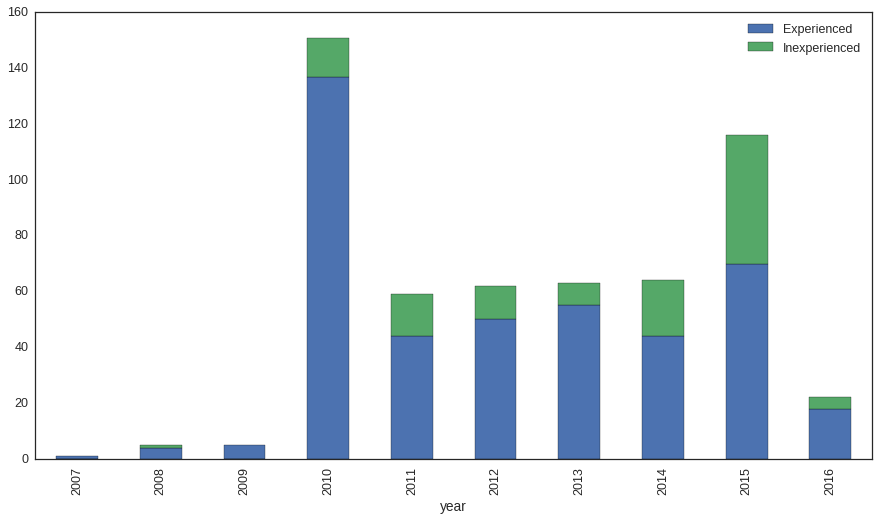

In [15]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

#How many days (to date) is considered experienced?
threshold = 7

gt_10 = overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
lt_10 = overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

gt_10.columns = ['Experienced']
lt_10.columns = ['Inexperienced']

gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)

# 2: User Experience 

Who's Mapping Buildings and Roads?

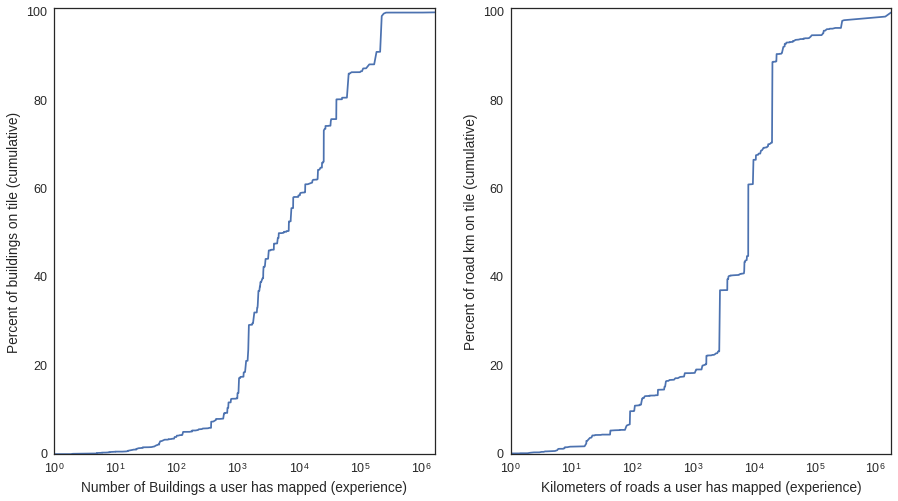

In [16]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

b_view = current_tile_df.sort_values(by='total_buildings_ever')
b_view['cumulative_percent'] = b_view.percent_tile_buildings.cumsum()

b_view.plot(ax=axs[0],x='total_buildings_ever',y='cumulative_percent', logx=True,legend=None)

axs[0].set_ylabel('Percent of buildings on tile (cumulative)')
axs[0].set_xlabel('Number of Buildings a user has mapped (experience)')


r_view = current_tile_df.sort_values(by='total_road_km_ever')
r_view['cumulative_percent'] = r_view.percent_tile_road_km.cumsum()

r_view.plot(ax=axs[1],x='total_road_km_ever',y='cumulative_percent', logx=True,legend=None)

axs[1].set_ylabel('Percent of road km on tile (cumulative)')
axs[1].set_xlabel('Kilometers of roads a user has mapped (experience)')

for ax in axs:
    ax.set_ylim(0,101)
    ax.set_xlim(1)

# 3. User Focus

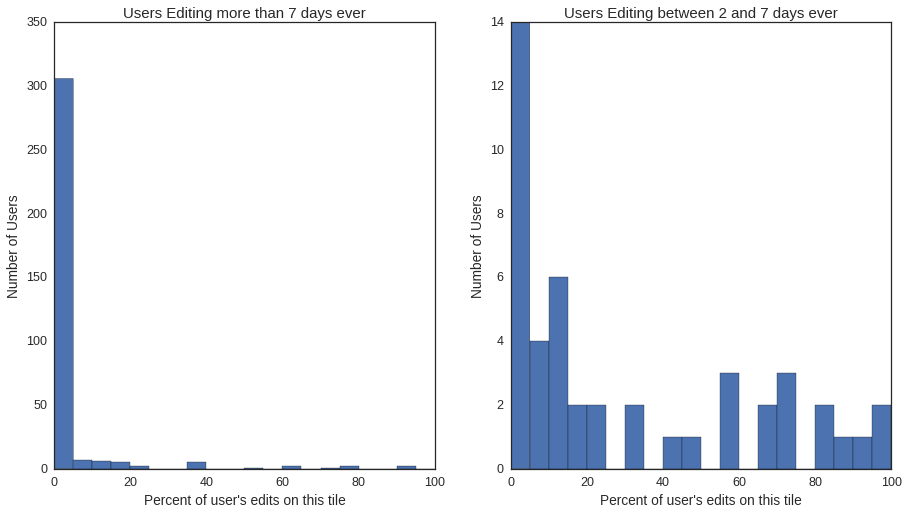

In [17]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

current_tile_df.query('total_editing_days_ever>7').query('total_editing_days_ever>1').plot(ax=axs[0], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[0].set_title('Users Editing more than 7 days ever')

current_tile_df.query('total_editing_days_ever<7').query('total_editing_days_ever>1').plot(ax=axs[1], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[1].set_title('Users Editing between 2 and 7 days ever')

for ax in axs:
    ax.set_xlabel("Percent of user's edits on this tile")
    ax.set_ylabel('Number of Users')

This is still not _quite_ right, there are better ways to show this type of _User Focus_

<br>
<hr>
<br>
<br>
# Run Tile-by-Tile Comparisons
For each study tile, we have _comparable_ tiles, these are the tiles of most interest, because the difference in patterns between these tiles and our study tiles is what makes the analysis.

#### 1. Get a _comparable_ tile

In [ ]:
if 'compare_tiles' in study_tiles[study_tile_idx]:
    print("Comparable Tiles for {0}: ".format(study_tiles[study_tile_idx]['name']))
    for idx, compare in enumerate(study_tiles[study_tile_idx]['compare_tiles']):
        print("\t{0}, '{1}'".format(idx, compare['quad']))

In [ ]:
#Which tile to compare? (from within the comparable study tiles)
compare_tile_idx=1

#### 2. Get Users

In [ ]:
reset()
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])

#### 3. Build actual user distribution (may take a few minutes)
If it fails, run the above cell again (probably twice)

In [ ]:
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'])

#### 4. Now process user focus for compare tiles

In [ ]:
process_dictionary_of_users(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'])
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'], study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['quad'])

display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['toi'].head(2))
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['tiles'].head(2))
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['annual'].head(2))

#### 5. Build Compare Tile Full Stats

In [ ]:
compare_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])
compare_tile_df.count().head(2)

In [ ]:
compare_overtime_df = get_active_users_overtime_df(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'])
compare_overtime_df.head(2)

<br>
<br>
<hr>

# Now we can compare Tacloban to its similar tiles

First, basic stats: 

In [ ]:
print("Users on Study Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['user_list']), len(current_tile_df)))
print("Users on Compare Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list']), len(compare_tile_df)))

# 1.  Users active on the tiles overtime

In [ ]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

#How many days (to date) is considered experienced?
threshold = 7
#Study Tile (Tacloban)
gt_10 = overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
lt_10 = overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
gt_10.columns = ['Experienced Contributors']
lt_10.columns = ['Inexperienced Contributors']
gt_10.join(lt_10).plot(ax=axs[0],kind='bar',stacked=True)

#Compare DF
compare_gt_10 = compare_overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
compare_lt_10 = compare_overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
compare_gt_10.columns = ['Experienced Contributors']
compare_lt_10.columns = ['Inexperienced Contributors']
compare_gt_10.join(compare_lt_10).plot(ax=axs[1],kind='bar',stacked=True)

axs[0].set_title(study_tiles[study_tile_idx]['name'],fontsize=18)
axs[0].set_ylabel("Users active each year",fontsize=18)
axs[1].set_title("Similar Tile",fontsize=18)

axs[1].set_ylim(axs[0].get_ylim())

for ax in axs:
    ax.legend_.remove()
    ax.set_xlabel("")

handles, labels = axs[1].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', ncol=2, fontsize=15)

# Percentage of a User's Edits on Each Tile

In [ ]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

current_tile_df.plot(ax=axs[0], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[0].set_title(study_tiles[study_tile_idx]['name'])

compare_tile_df.plot(ax=axs[1], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[1].set_title(study_tiles[study_tile_idx]['compare_tiles'][idx]['quad'])

for ax in axs:
    ax.set_xlabel("Percent of User's Edits on Tile")
    ax.set_ylabel('Number of Users')
plt.suptitle("Percentage of a User's Edits (total) Occuring on this tile",fontsize=18)
None

# Compare Buildings & Roads Across Two _Similar_ Tiles

In [ ]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

#Buildings
b_axis = axs[0]
b_view = current_tile_df.sort_values(by='total_buildings_ever')
b_view['cumulative_percent'] = b_view.percent_tile_buildings.cumsum()
b_view.plot(ax=b_axis,x='total_buildings_ever',y='cumulative_percent', logx=True,label=study_tiles[study_tile_idx]['name'])

compare_b_view = compare_tile_df.sort_values(by='total_buildings_ever')
compare_b_view['cumulative_percent'] = compare_b_view.percent_tile_buildings.cumsum()
compare_b_view.plot(ax=b_axis,x='total_buildings_ever',y='cumulative_percent', logx=True,label="Similar Tile")

b_axis.set_ylabel('Percent of buildings on tile (cumulative)')
b_axis.set_xlabel('Number of Buildings a user has mapped (experience)')

#Roads
r_axis = axs[1]
r_view = current_tile_df.sort_values(by='total_road_km_ever')
r_view['cumulative_percent'] = r_view.percent_tile_road_km.cumsum()
r_view.plot(ax=r_axis,x='total_road_km_ever',y='cumulative_percent', logx=True,label=study_tiles[study_tile_idx]['name'])

compare_r_view = compare_tile_df.sort_values(by='total_road_km_ever')
compare_r_view['cumulative_percent'] = compare_r_view.percent_tile_road_km.cumsum()
compare_r_view.plot(ax=r_axis,x='total_road_km_ever',y='cumulative_percent', logx=True,label="Similar Tile")

r_axis.set_ylabel('Percent of road km on tile (cumulative)')
r_axis.set_xlabel('Kilometers of roads a user has mapped (experience)')

for ax in [r_axis, b_axis]:
    ax.set_ylim(0,101)
    ax.set_xlim(1)